In [1]:
import os
import json
import gensim
import pandas as pd
import matplotlib.pyplot as plt

import string
import pickle
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
PATH_bva = "../data/annotations/20180415_bva.json"
PATH_cyber = "../data/annotations/20180415_cyber_crime.json"
PATH_intellectual = "../data/annotations/20180415_intellectual_property.json"
PATH_scotus = "../data/annotations/20180415_scotus.json"

train_PATHS = [PATH_bva, PATH_intellectual, PATH_scotus]
test_PATHS = [PATH_cyber]

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

In [4]:


def tockenizer_C(text):
    output = []
    start = 0
    type_ = None

    for pos, char in enumerate(text):
        curr_type = None

        if char.isdigit():
            curr_type = "DIGITS"

        elif char in string.punctuation or char == " ":
            curr_type = "SYMBOLS"

        elif char.isalpha():
            curr_type = "ALPHA"

        if curr_type!=type_:

            if text[start:pos]!="":
                output.append(text[start:pos])

            start = pos

            if curr_type == "SYMBOLS":
                output.append(text[pos])
                start+=1

        elif pos == len(text)-1:
            output.append(text[start:])

        type_ = curr_type

        if curr_type == "SYMBOLS":
            type_ = None


    return output

def inrange(pos, s, e):
    for i,j in zip(s,e):
        if pos<=j and pos>=i :
            return True

    return False
        


def dataset_gen(x, window_size=20):
    dataset = json.load(open(x, "r", encoding="utf8"))
    x_l = []
    x_r = []
    y = []

    for doc in dataset:
        text = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
        offsets = dataset[doc]['annotations']
        text = tockenizer_C(text)
        start, end = [], []

        for i in offsets:
            start.append(i['start'])
            end.append(i['end'])


        pointer = 0
        for pos, char in enumerate(text):
            pointer+= len(char)   
            if char == ".":
                
                if pointer in end:
                    y.append(1)  

                else:
                    y.append(0) 

                left, right =[], []

                move = 1
                while len(left)!=window_size:
                    if pos-move<0:
                        left = [" "]+left

                    elif text[pos-move] != " ":
                        left = [text[pos-move]] + left

                    move = move+1

                move = 1
                while len(right)!=window_size:
                    if len(text)<=move+pos:
                        right.append(" ")

                    elif text[pos+move] != " ":
                        right.append(text[pos+move])

                    move = move+1

                x_l.append(' '.join(left))
                x_r.append(' '.join(right))

                         
                

    return x_l, x_r, y

test_x_l, test_x_r,test_y = [], [], []

train_x_l, train_x_r, train_y = [], [], []

for paths in train_PATHS:
    x_l, x_r, y = dataset_gen(paths)
    train_x_l = train_x_l + x_l
    train_x_r = train_x_r + x_r
    train_y = train_y + y


for paths in test_PATHS:
    x_l, x_r, y = dataset_gen(paths)
    test_x_l = test_x_l + x_l
    test_x_r = test_x_r + x_r
    test_y = test_y + y
    # print(x, y)
    # break


# print(len(train_x), len(test_x))

train_x_l = dict(tokenizer(train_x_l))
train_x_r = dict(tokenizer(train_x_r))


test_x_l = dict(tokenizer(test_x_l))
test_x_r = dict(tokenizer(test_x_r))

# print(len(train_x), len(test_x))

In [5]:
def gensubwordtokens(train_x_l, train_x_r):
    train_x = {'input_ids':[], 'attention_mask':[], 'token_type_ids':[]}
    for l,r in zip(train_x_l, train_x_r):
        l = l[-7:-1]
        r = r[1:7]
        while len(l)!=6:
            l = [0]+l
        while len(r)!=6:
            r = r + [0]

        train_x['input_ids'].append([101]+l+r+[102])
        train_x['attention_mask'].append([1]*14)
        train_x['token_type_ids'].append([0]*14)

    return train_x


train_x = gensubwordtokens(train_x_l['input_ids'][:-1600], train_x_r['input_ids'][:-1600])
val_x = gensubwordtokens(train_x_l['input_ids'][-1600:], train_x_r['input_ids'][-1600:])
test_x = gensubwordtokens(test_x_l['input_ids'], test_x_r['input_ids'])

In [6]:
import torch

class custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = custom_Dataset(train_x, train_y[:-1600])
val_dataset = custom_Dataset(val_x, train_y[-1600:])
test_dataset = custom_Dataset(test_x, test_y)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

window_size = 6

In [7]:
def TF_PN(pred, target):
    x = [0,0,0,0] #TP, TN, FP, FN
    for i, j in zip(pred, target):
        # print(i,j)
        if i[0]>i[1]:
            i=0
        
        else:
            i=1

        j = int(j)

        # print(i,j)
    
        if i == 0:
            if j == 0:
                x[1]+=1
            else:
                x[3]+=1

        else:
            if j == 0:
                x[2]+=1
            else:
                x[0]+=1


    return x

def accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def acc_recall_precision_f1(y_pred, y):
    i = TF_PN(y_pred, y)
    # print(i)
    acc = accuracy(i)
    rec = recall(i)
    prec = precision(i)
    f1 = f1_score(i)
    specificity_ = specificity(i)

    return acc, rec, prec, f1, specificity_

In [31]:

def BIL_model(model, text):
    device = 'cuda'
    text = text.replace("\r","\n").replace("\t","\n")
    text_str = text
    x_l, x_r = [], []
    offsets = []
    text = tockenizer_C(text)

    pointer = 0
    for pos, char in enumerate(text):
        pointer+= len(char)   
        if char == ".":
            left, right =[], []
            move = 1
            while len(left)!=20:
                if pos-move<0:
                    left = [" "]+left
                elif text[pos-move] != " ":
                    left = [text[pos-move]] + left
                move = move+1
            move = 1
            while len(right)!=20:
                if len(text)<=move+pos:
                    right.append(" ")
                elif text[pos+move] != " ":
                    right.append(text[pos+move])
                move = move+1
            x_l.append(' '.join(left))
            x_r.append(' '.join(right))
            offsets.append(pointer-1)
            
                
    x_l = dict(tokenizer(x_l))
    x_r = dict(tokenizer(x_r))

    x = gensubwordtokens(x_l['input_ids'], x_r['input_ids'])
    # print(x)
    pred_dataset = custom_Dataset(x, [1]*len(x['input_ids']))
    pred_dataloader = DataLoader(pred_dataset, batch_size=32, shuffle=False)

    pred_x_total = []

    for batch in pred_dataloader:
        model.eval()
        # optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        pred_x_total += model(input_ids).logits.cpu().detach().numpy().tolist()


    
    pred_offsets = []

    for each_pred in pred_x_total:
        if each_pred[0]>each_pred[1]:
            pred_offsets.append(0)

        else:
            pred_offsets.append(1)


    output = []
    start = 0

    for i,j in zip(offsets, pred_offsets):
        if j == 1:
            output.append(text_str[start:i+1])
            start = i+1

    return output

def BIL_TF_PN(original, pred):
    original = original.replace("\n"," ").split()
    pred = pred.split()

    # print(original)
    # print(pred)
    
    beggining = [0, 0, 0, 0] #TP, TN, FP, FN
    end = [0, 0, 0, 0]
    i_max = [0, 0, 0, 0]

    if original[0] == pred[0]:
        beggining[0]+=1
        i_max[1]+=1
        end[1]+=1

    else:
        beggining[2]+=1
        i_max[3]+=1

    if original[-1] == pred[-1]:
        end[0]+=1
        i_max[1]+=1
        beggining[1]+=1

    else:
        end[2]+=1
        i_max[3]+=1

    change = False
    for pos in range(len(original)):
        # print(i_max[0], len(pred))
        if i_max[0] == len(pred):
            beggining[3] =0
            break
        
        if original[pos] != pred[0]:
            continue

        else:
            change = True
        
        i = [0, 0, 0, 0] #TP, TN, FP, FN
        temp_beg = beggining
        temp_end = end

        tip = len(original) if original < pred else pred

        for nth, (x, y) in enumerate(zip(range(pos, len(original)), range(len(pred)))):
            if original[x]==pred[y]:
                i[0]+=1
                temp_beg[1]+=1
                temp_end[1]+=1

            else:
                i[2]+=1
                temp_beg[1]+=1
                if nth!=tip:
                    temp_end[3]+=1


        if i[0]>i_max[0]:
            i_max = i
            if temp_beg[3]==0 and pos!=0:
                temp_beg[3]+=1

        elif i[0]==i_max[0] and (i[2] == 0) :
            i_max = i


            beggining = temp_beg
            end = temp_end
        

    if not change:
        i_max[2] = len(pred)-1

    return beggining, i_max, len(original), len(pred),  end


def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")

def check_range(pointer_start, pointer_end, ranges):
    intersection_dict = {}
    for i in ranges:
        if pointer_start>=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - i['start'], abs(i['start']-pointer_start)]
        
        if pointer_start>=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - i['start'], abs(i['start']-pointer_start)]

    max_intersection_key = None
    max_intersection_len = -1
    max_intersection_start_dist = 1000000
    
    for i in intersection_dict.keys():
        if intersection_dict[i][0]>max_intersection_len or (intersection_dict[i][0]==max_intersection_len and max_intersection_start_dist<intersection_dict[i][1]):
            max_intersection_len =  intersection_dict[i][0]
            max_intersection_key = i
            max_intersection_start_dist = intersection_dict[i][1]

    return max_intersection_key


def BIL_accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def BIL_recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def BIL_precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def BIL_f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def BIL_specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def BIL_acc_recall_precision_f1(x):
    acc, rec, prec, f1, specificity_  = 0, 0, 0, 0, 0
    t = 0
    for i in x:
        acc = acc + BIL_accuracy(i)
        rec = rec + BIL_recall(i)
        prec = prec + BIL_precision(i)
        f1 = f1 + BIL_f1_score(i)
        specificity_ = specificity_ + BIL_specificity(i)
        

    return acc/len(x), rec/len(x), prec/len(x), f1/len(x), specificity_/len(x)


def BIL_results(model, timer=False):
    results = {}
    total_time = 0

    for path_ in test_PATHS:
        dataset = json.load(open(path_, "r", encoding="utf8"))
        results[path_] = []
        for doc in dataset:
            x = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
            y = []
            for sentence in dataset[doc]['annotations']:
                y.append(dataset[doc]['text'][sentence['start']:sentence['end']])

            start_time = time.time()
            pred = BIL_model(model, x)

            if timer:
                print("--- Model took %s seconds to predict ---" % (time.time() - start_time))
            
            total_time = total_time + (time.time() - start_time)
            # print(len(y), len(pred))


            pointer = 0
            mappings = []
            filtred_pred = []

            for pred_sentences in pred:
                maped = check_range(pointer, pointer+len(pred_sentences), dataset[doc]['annotations'])
                # if maped != None:
                #     print(raw_str(pred_sentences), raw_str(dataset['59bd4ac35116540935ee6851']['text'][int(maped.split('-')[0]):int(maped.split('-')[1])]), sep=" ====== ", end="\n\n")

                pointer+=len(pred_sentences)

                pred_sentences = pred_sentences.replace("\n"," ")

                if maped is not None :
                    mappings.append(dataset[doc]['text'][int(maped.split('-')[0]):int(maped.split('-')[1])])
                    filtred_pred.append(pred_sentences)
                    results[path_].append(BIL_TF_PN(mappings[-1], filtred_pred[-1]))

    for paths in results:
        B = []
        I = []
        L = []

        for i in results[paths]:
            B.append(i[0])
            I.append(i[1])
            L.append(i[-1])


        if len(B)!=0:
            print(f"B : {BIL_acc_recall_precision_f1(B)}")
        
        if len(I)!=0:
            print(f"I : {BIL_acc_recall_precision_f1(I)}")
        
        if len(L)!=0:
            print(f"L : {BIL_acc_recall_precision_f1(L)}\n")

        if timer:
            print(f"--- Model took a total of {total_time} seconds to predict all the documents ---")

      
        # return BIL_acc_recall_precision_f1(B), BIL_acc_recall_precision_f1(I), BIL_acc_recall_precision_f1(L)


In [15]:
from transformers import AutoModelForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=2)
model.to(device)
model.train()


optim = AdamW(model.parameters(), lr=5e-5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [10]:
train_n_minibatches = train_loader.__len__()
validation_n_minibatches = val_loader.__len__()

In [11]:
loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []

best_val_f1 = 0

best_val_acc = 0
best_val_prec = 0
best_val_recall = 0
best_val_spec = 0

EPOCH = 10

import time

total_time = 0

for e in range(EPOCH):
    start_time = time.time()
    for i, batch in enumerate(train_loader):
        model.train()
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]

        loss_history[0].append(loss)

        loss.backward()
        optim.step()

        model.eval()
        outputs = model(input_ids).logits.cpu().detach().numpy().tolist()
        acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(outputs, labels.cpu().detach().numpy().tolist())
        accuracy_history[0].append(acc)
        recall_history[0].append(rec)
        prec_history[0].append(prec)
        f1_history[0].append(f1)
        specifity_history[0].append(specificity_)

        print(f"TRAIN MINIBATCH {i}/{train_n_minibatches}", end="\r")

    print(
        f"---------------------------------------EPOCH {e+1}-------------------------------------------"
    )
    print(
        f"TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}",
        end=" ",
    )
    print(
        f"TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN RECALL : {sum(recall_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN PRECISION : {sum(prec_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN F1 : {sum(f1_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN SPECIFITY : {sum(specifity_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}"
    )

    total_time = total_time + time.time() - start_time
    print("--- Trainining for this epoch took %s seconds ---" % (time.time() - start_time))
    
    with torch.no_grad():
           for i, batch in enumerate(val_loader):
                model.train()
                optim.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs[0]
                loss_history[0].append(loss)

                model.eval()
                outputs = model(input_ids).logits.cpu().detach().numpy().tolist()
                acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(outputs, labels.cpu().detach().numpy().tolist())
                accuracy_history[1].append(acc)
                recall_history[1].append(rec)
                prec_history[1].append(prec)
                f1_history[1].append(f1)
                specifity_history[1].append(specificity_)

                print(f"VAL MINIBATCH {i}/{validation_n_minibatches}", end="\r")

    print(
        f"VALIDATION LOSS : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}",
        end=" ",
    )
    print(
        f"VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION RECALL : {sum(recall_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION PRECISION : {sum(prec_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION F1 : {sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION SPECIFITY : {sum(specifity_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}"
    )

    print(
        "---------------------------------------------------------------------------------------------\n\n"
    )

    BIL_history.append(BIL_results(model))

    if best_val_f1<sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches:

        best_val_f1 = sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches

        best_val_f1 = sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_prec = sum(prec_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_recall = sum(recall_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_spec = sum(specifity_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches

model.eval()

---------------------------------------EPOCH 1-------------------------------------------
TRAIN LOSS : 0.10192134231328964 TRAIN ACCURACY : 0.9716109154929577 TRAIN RECALL : 0.9588089427471296 TRAIN PRECISION : 0.9590406485237163 TRAIN F1 : 0.9567380871397105 TRAIN SPECIFITY : 0.9795642051162037
--- Trainining for this epoch took 93.36277389526367 seconds ---
VALIDATION LOSS : 0.0 VALIDATION ACCURACY : 0.95625 VALIDATION RECALL : 0.9074585887968241 VALIDATION PRECISION : 0.9746825396825396 VALIDATION F1 : 0.937610149494667 VALIDATION SPECIFITY : 0.9857599912165129
---------------------------------------------------------------------------------------------


B : (0.8992765080601348, 0.8222222222222222, 0.8222222222222222, 0.8222222222222222, 0.8996772432068701)
I : (0.8363575468381803, 0.835881753312946, 0.8303972555247201, 0.8310912714727757, 0.006619423932515167)
L : (0.9551433330212243, 0.8574939879965864, 0.8615698267074414, 0.8577749741128994, 0.8301697224942284)

----------------

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
print(best_val_f1, best_val_acc, best_val_prec, best_val_recall, best_val_spec)

0.9601383204586483 0 0.9544346960229312 0.9699585064058744 0.971755018034766


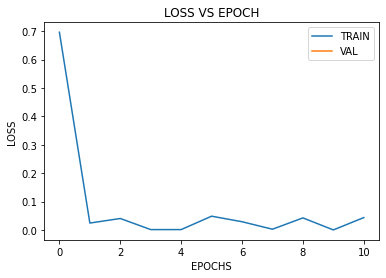

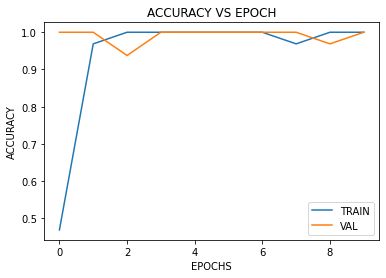

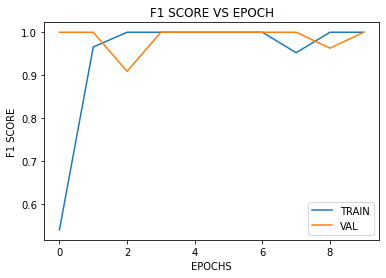

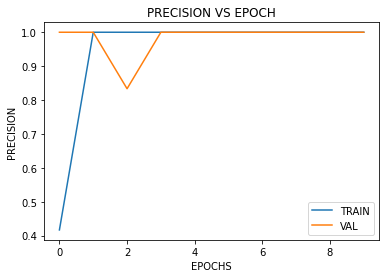

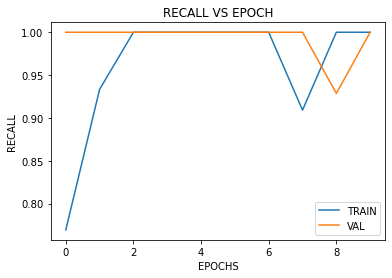

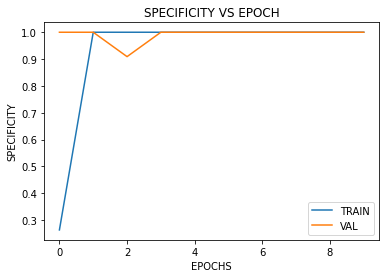

In [13]:
for pos in range(len(loss_history[0])):
    loss_history[0][pos] = loss_history[0][pos].detach().cpu().tolist()

for pos in range(len(loss_history[1])):
    loss_history[1][pos] = loss_history[1][pos].detach().cpu().tolist()

plt.plot(loss_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(loss_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title("LOSS VS EPOCH")
plt.legend()
plt.show()

plt.plot(accuracy_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(accuracy_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.title("ACCURACY VS EPOCH")
plt.legend()
plt.show()

plt.plot(f1_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(f1_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('F1 SCORE')
plt.title("F1 SCORE VS EPOCH")
plt.legend()
plt.show()

plt.plot(prec_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(prec_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('PRECISION')
plt.title("PRECISION VS EPOCH")
plt.legend()
plt.show()

plt.plot(recall_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(recall_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('RECALL')
plt.title("RECALL VS EPOCH")
plt.legend()
plt.show()

plt.plot(specifity_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(specifity_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('SPECIFICITY')
plt.title("SPECIFICITY VS EPOCH")
plt.legend()
plt.show()



In [14]:
pickle.dump([loss_history, accuracy_history, prec_history, recall_history, f1_history, specifity_history, BIL_history] ,open(f"results/BERT_train_analysis.pkl", "wb"))

In [15]:
loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []

test_n_minibatches = test_loader.__len__()

with torch.no_grad():
    for batch in test_loader:
         model.train()
         optim.zero_grad()
         input_ids = batch['input_ids'].to(device)
         attention_mask = batch['attention_mask'].to(device)
         labels = batch['labels'].to(device)
         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
         loss = outputs[0]
         loss_history[1].append(loss)
         model.eval()
         
         outputs = model(input_ids).logits.cpu().detach().numpy().tolist()
         acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(outputs, labels.cpu().detach().numpy().tolist())
         accuracy_history[1].append(acc)
         recall_history[1].append(rec)
         prec_history[1].append(prec)
         f1_history[1].append(f1)
         specifity_history[1].append(specificity_)
# Saving the model progress

# Log for e+1th epoch
print(
    f"TEST LOSS : {sum(loss_history[1][-1:-1*test_n_minibatches-1:-1])/test_n_minibatches}",
    end=" ",
)
print(
    f"TEST ACCURACY : {sum(accuracy_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST RECALL : {sum(recall_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST PRECISION : {sum(prec_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST F1 : {sum(f1_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST SPECIFITY : {sum(specifity_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}"
)
print(
    "---------------------------------------------------------------------------------------------\n\n"
)

TEST LOSS : 0.11908764392137527 TEST ACCURACY : 0.9791095890410959 TEST RECALL : 0.9767561480487182 TEST PRECISION : 0.9752908889038499 TEST F1 : 0.9750847551402664 TEST SPECIFITY : 0.9810345065609535
---------------------------------------------------------------------------------------------




In [33]:
BIL_results(model, timer=True)

--- Model took 0.28951311111450195 seconds to predict ---
--- Model took 0.5044777393341064 seconds to predict ---
--- Model took 0.19934844970703125 seconds to predict ---
--- Model took 0.5209498405456543 seconds to predict ---
--- Model took 0.33675265312194824 seconds to predict ---
--- Model took 0.5208883285522461 seconds to predict ---
--- Model took 0.28952980041503906 seconds to predict ---
--- Model took 0.6818757057189941 seconds to predict ---
--- Model took 0.20115113258361816 seconds to predict ---
--- Model took 0.361588716506958 seconds to predict ---
--- Model took 0.38905978202819824 seconds to predict ---
--- Model took 0.23436856269836426 seconds to predict ---
--- Model took 0.7159674167633057 seconds to predict ---
--- Model took 0.717214822769165 seconds to predict ---
--- Model took 0.12150692939758301 seconds to predict ---
--- Model took 0.25824475288391113 seconds to predict ---
--- Model took 0.15597033500671387 seconds to predict ---
--- Model took 0.417038

In [24]:
pickle.dump([loss_history, accuracy_history, prec_history, recall_history, f1_history, specifity_history, BIL_history] ,open(f"results/LegalBERT_subword_test_analysis.pkl", "wb"))

In [25]:
model.save_pretrained("saved_models/LegalBERT_subword/")
tokenizer.save_pretrained("saved_models/LegalBERT_subword/")

('saved_models/LegalBERT_subword/tokenizer_config.json',
 'saved_models/LegalBERT_subword/special_tokens_map.json',
 'saved_models/LegalBERT_subword/vocab.txt',
 'saved_models/LegalBERT_subword/added_tokens.json',
 'saved_models/LegalBERT_subword/tokenizer.json')

: 

In [11]:

def BIL_model(model, text):
    device = 'cpu'
    text = text.replace("\r","\n").replace("\t","\n")
    text_str = text
    x_l, x_r = [], []
    offsets = []
    text = tockenizer_C(text)

    pointer = 0
    for pos, char in enumerate(text):
        pointer+= len(char)   
        if char == ".":
            left, right =[], []
            move = 1
            while len(left)!=20:
                if pos-move<0:
                    left = [" "]+left
                elif text[pos-move] != " ":
                    left = [text[pos-move]] + left
                move = move+1
            move = 1
            while len(right)!=20:
                if len(text)<=move+pos:
                    right.append(" ")
                elif text[pos+move] != " ":
                    right.append(text[pos+move])
                move = move+1
            x_l.append(' '.join(left))
            x_r.append(' '.join(right))
            offsets.append(pointer-1)
            
                
    x_l = dict(tokenizer(x_l))
    x_r = dict(tokenizer(x_r))

    x = gensubwordtokens(x_l['input_ids'], x_r['input_ids'])
    # print(x)
    pred_dataset = custom_Dataset(x, [1]*len(x['input_ids']))
    pred_dataloader = DataLoader(pred_dataset, batch_size=32, shuffle=False)

    pred_x_total = []

    for batch in pred_dataloader:
        model.eval()
        # optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        pred_x_total += model(input_ids).logits.cpu().detach().numpy().tolist()


    
    pred_offsets = []

    for each_pred in pred_x_total:
        if each_pred[0]>each_pred[1]:
            pred_offsets.append(0)

        else:
            pred_offsets.append(1)


    output = []
    start = 0

    for i,j in zip(offsets, pred_offsets):
        if j == 1:
            output.append(text_str[start:i+1])
            start = i+1

    return output

def BIL_TF_PN(original, pred):
    original = original.replace("\n"," ").split()
    pred = pred.split()

    # print(original)
    # print(pred)
    
    beggining = [0, 0, 0, 0] #TP, TN, FP, FN
    end = [0, 0, 0, 0]
    i_max = [0, 0, 0, 0]

    if original[0] == pred[0]:
        beggining[0]+=1
        i_max[1]+=1
        end[1]+=1

    else:
        beggining[2]+=1
        i_max[3]+=1

    if original[-1] == pred[-1]:
        end[0]+=1
        i_max[1]+=1
        beggining[1]+=1

    else:
        end[2]+=1
        i_max[3]+=1

    change = False
    for pos in range(len(original)):
        # print(i_max[0], len(pred))
        if i_max[0] == len(pred):
            beggining[3] =0
            break
        
        if original[pos] != pred[0]:
            continue

        else:
            change = True
        
        i = [0, 0, 0, 0] #TP, TN, FP, FN
        temp_beg = beggining
        temp_end = end

        tip = len(original) if original < pred else pred

        for nth, (x, y) in enumerate(zip(range(pos, len(original)), range(len(pred)))):
            if original[x]==pred[y]:
                i[0]+=1
                temp_beg[1]+=1
                temp_end[1]+=1

            else:
                i[2]+=1
                temp_beg[1]+=1
                if nth!=tip:
                    temp_end[3]+=1


        if i[0]>i_max[0]:
            i_max = i
            if temp_beg[3]==0 and pos!=0:
                temp_beg[3]+=1

        elif i[0]==i_max[0] and (i[2] == 0) :
            i_max = i


            beggining = temp_beg
            end = temp_end
        

    if not change:
        i_max[2] = len(pred)-1

    return beggining, i_max, len(original), len(pred),  end


def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")

def check_range(pointer_start, pointer_end, ranges):
    intersection_dict = {}
    for i in ranges:
        if pointer_start>=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - i['start'], abs(i['start']-pointer_start)]
        
        if pointer_start>=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - i['start'], abs(i['start']-pointer_start)]

    max_intersection_key = None
    max_intersection_len = -1
    max_intersection_start_dist = 1000000
    
    for i in intersection_dict.keys():
        if intersection_dict[i][0]>max_intersection_len or (intersection_dict[i][0]==max_intersection_len and max_intersection_start_dist<intersection_dict[i][1]):
            max_intersection_len =  intersection_dict[i][0]
            max_intersection_key = i
            max_intersection_start_dist = intersection_dict[i][1]

    return max_intersection_key


def BIL_accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def BIL_recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def BIL_precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def BIL_f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def BIL_specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def BIL_acc_recall_precision_f1(x):
    acc, rec, prec, f1, specificity_  = 0, 0, 0, 0, 0
    t = 0
    for i in x:
        acc = acc + BIL_accuracy(i)
        rec = rec + BIL_recall(i)
        prec = prec + BIL_precision(i)
        f1 = f1 + BIL_f1_score(i)
        specificity_ = specificity_ + BIL_specificity(i)
        

    return acc/len(x), rec/len(x), prec/len(x), f1/len(x), specificity_/len(x)


def BIL_results(model, timer=False):
    results = {}
    total_time = 0

    for path_ in test_PATHS:
        dataset = json.load(open(path_, "r", encoding="utf8"))
        results[path_] = []
        for doc in dataset:
            x = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
            y = []
            for sentence in dataset[doc]['annotations']:
                y.append(dataset[doc]['text'][sentence['start']:sentence['end']])

            start_time = time.time()
            pred = BIL_model(model, x)

            if timer:
                print("--- Model took %s seconds to predict ---" % (time.time() - start_time))
            
            total_time = total_time + (time.time() - start_time)
            # print(len(y), len(pred))


            pointer = 0
            mappings = []
            filtred_pred = []

            for pred_sentences in pred:
                maped = check_range(pointer, pointer+len(pred_sentences), dataset[doc]['annotations'])
                # if maped != None:
                #     print(raw_str(pred_sentences), raw_str(dataset['59bd4ac35116540935ee6851']['text'][int(maped.split('-')[0]):int(maped.split('-')[1])]), sep=" ====== ", end="\n\n")

                pointer+=len(pred_sentences)

                pred_sentences = pred_sentences.replace("\n"," ")

                if maped is not None :
                    mappings.append(dataset[doc]['text'][int(maped.split('-')[0]):int(maped.split('-')[1])])
                    filtred_pred.append(pred_sentences)
                    results[path_].append(BIL_TF_PN(mappings[-1], filtred_pred[-1]))

    for paths in results:
        B = []
        I = []
        L = []

        for i in results[paths]:
            B.append(i[0])
            I.append(i[1])
            L.append(i[-1])


        if len(B)!=0:
            print(f"B : {BIL_acc_recall_precision_f1(B)}")
        
        if len(I)!=0:
            print(f"I : {BIL_acc_recall_precision_f1(I)}")
        
        if len(L)!=0:
            print(f"L : {BIL_acc_recall_precision_f1(L)}\n")

        if timer:
            print(f"--- Model took a total of {total_time} seconds to predict all the documents ---")

from transformers import AutoModelForSequenceClassification
        # return BIL_acc_recall_precision_f1(B), BIL_acc_recall_precision_f1(I), BIL_acc_recall_precision_f1(L)
model = AutoModelForSequenceClassification.from_pretrained("saved_models/LegalBERT_subword", num_labels=2)
BIL_results(model.to('cpu'), timer=True)

--- Model took 3.6279685497283936 seconds to predict ---
--- Model took 6.940419435501099 seconds to predict ---
--- Model took 2.805525541305542 seconds to predict ---
--- Model took 7.036294460296631 seconds to predict ---
--- Model took 5.898640155792236 seconds to predict ---
--- Model took 11.495477199554443 seconds to predict ---
--- Model took 5.890914678573608 seconds to predict ---
--- Model took 12.400951862335205 seconds to predict ---
--- Model took 3.5535733699798584 seconds to predict ---
--- Model took 6.465251207351685 seconds to predict ---
--- Model took 5.868612051010132 seconds to predict ---
--- Model took 4.11139440536499 seconds to predict ---
--- Model took 5.676303148269653 seconds to predict ---
--- Model took 10.57387638092041 seconds to predict ---
--- Model took 2.281059741973877 seconds to predict ---
--- Model took 3.6040802001953125 seconds to predict ---
--- Model took 2.205260753631592 seconds to predict ---
--- Model took 6.254762172698975 seconds to 